<a href="https://colab.research.google.com/github/andre-marcos/time_series/blob/main/bit_coin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests

# Montagem da URL, conectando na API da Coinbase para recuperar os dados de Bitcoin
product_id = 'BTC-USD'
url = f"https://api.exchange.coinbase.com/products/{product_id}/candles"

# Definição dos parâmetros da API

# granularidade diária
granularity = 86400

# período de tempo no formato ISO
start_date = "2021-12-01T00:00:00"
end_date = "2022-01-31T23:59:59"

params = {
    "start": start_date,
    "end": end_date,
    "granularity": granularity
}

# Definindo os request headers
headers = {"content-type": "application/json"}

data = requests.get(url, params=params, headers=headers)
data

<Response [200]>

In [3]:
# transformando os dados baixados em json
data = data.json()

# exibindo os 5 primeiros itens dos dados
data[:5]

[[1643587200, 36640.94, 38785.04, 37904.99, 38491.93, 19654.98487168],
 [1643500800, 37365.31, 38384.07, 38189.82, 37901.35, 10632.53591257],
 [1643414400, 37300, 38748.43, 37741.9, 38191.1, 13103.19076443],
 [1643328000, 36162.48, 38023.74, 37188.37, 37741.9, 22716.16494796],
 [1643241600, 35526.36, 37249, 36846.22, 37188.37, 23601.4620954]]

In [4]:
# transformação da lista em dataframe

import pandas as pd

#nomeando as colunas
columns = ['timestamp', "low", "high", "open", "close", "volume"]

# criando o dataframe com os resultados
df = pd.DataFrame(data=data, columns=columns)

# criando a coluna datetime, setando ela como um índice e dando um drop na coluna timestamp
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('datetime', inplace=True)
df.drop('timestamp', axis=1, inplace=True)

df

,low,high,open,close,volume
datetime,,,,,
2022-01-31,36640.94,38785.04,37904.99,38491.93,19654.984872
2022-01-30,37365.31,38384.07,38189.82,37901.35,10632.535913
2022-01-29,37300.00,38748.43,37741.90,38191.10,13103.190764
2022-01-28,36162.48,38023.74,37188.37,37741.90,22716.164948
2022-01-27,35526.36,37249.00,36846.22,37188.37,23601.462095
...,...,...,...,...,...
2021-12-05,47827.00,49783.00,49235.26,49484.22,21727.138212
2021-12-04,42333.00,53876.09,53633.02,49241.12,39023.329785
2021-12-03,51640.00,57670.68,56521.45,53638.04,19567.631138


In [5]:
#informação do preço máximo de BTC no período

max_value = df['high'].max()
print(f"Preço máximo de BTC entre {start_date[:10]} e {end_date[:10]} foi ${max_value}")

Preço máximo de BTC entre 2021-12-01 e 2022-01-31 foi $59118.84


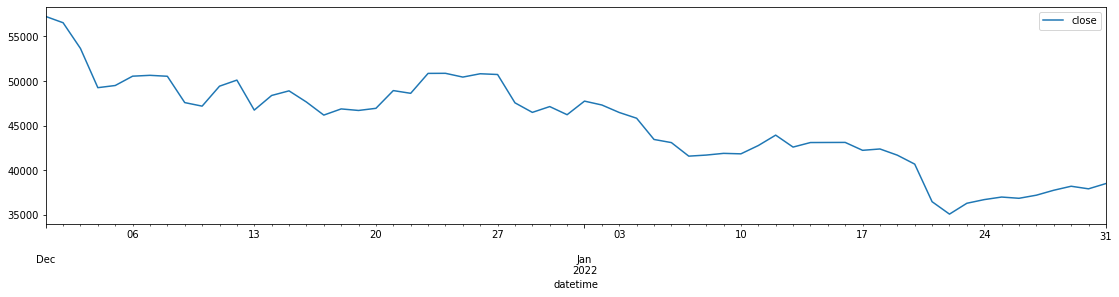

In [6]:
# decomposição da série

import matplotlib.pyplot as plt

#dropando colunas para manter somente data e fechamento da moeda
df.drop('low', axis=1, inplace=True)
df.drop('high', axis=1, inplace=True)
df.drop('open', axis=1, inplace=True)
df.drop('volume', axis=1, inplace=True)

#plotando gráfico
df.plot(figsize = (19, 4)) 
plt.show()

In [7]:
# contagem de linhas

with pd.option_context('display.max_rows',10):
  print(df)

               close
datetime            
2022-01-31  38491.93
2022-01-30  37901.35
2022-01-29  38191.10
2022-01-28  37741.90
2022-01-27  37188.37
...              ...
2021-12-05  49484.22
2021-12-04  49241.12
2021-12-03  53638.04
2021-12-02  56521.46
2021-12-01  57226.50

[62 rows x 1 columns]


In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

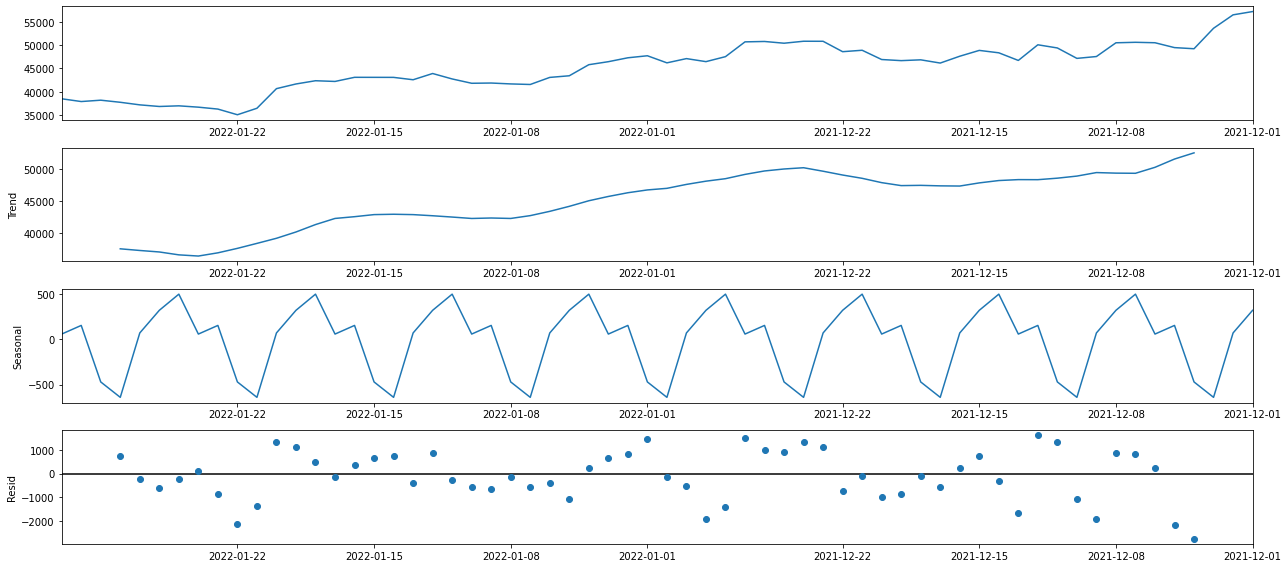

In [9]:
#decomposição aditiva

import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(x=df, model='additive')
fig = decomposition.plot()
plt.show()

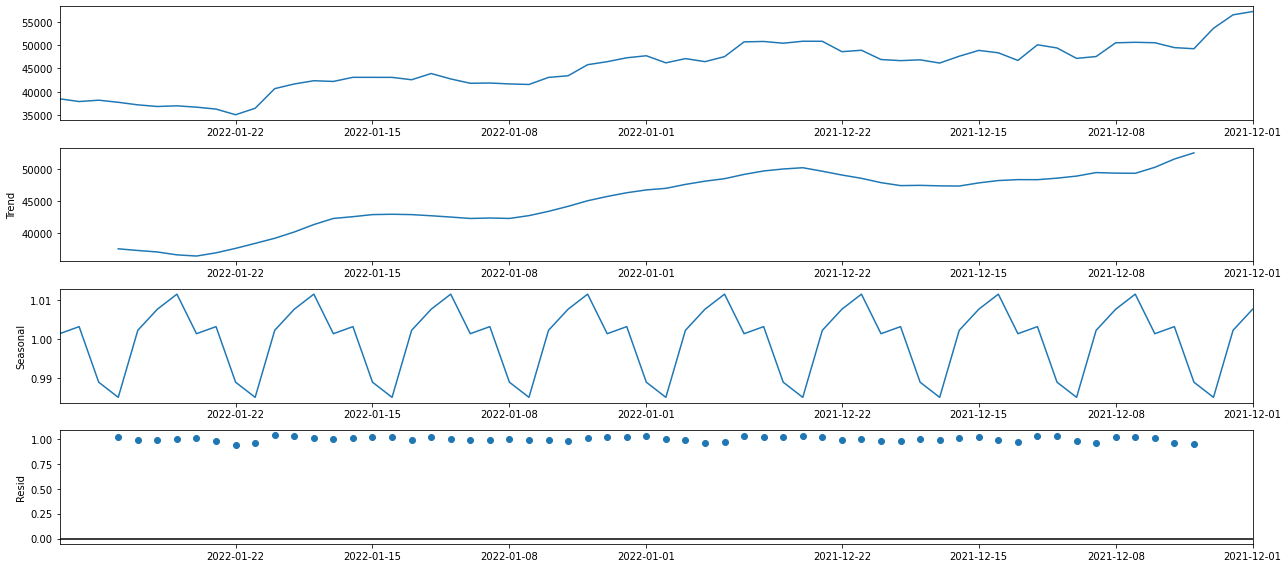

In [10]:
#decomposição multiplicativa

decomposition = sm.tsa.seasonal_decompose(x=df, model='multiplicative')
fig = decomposition.plot()
plt.show()

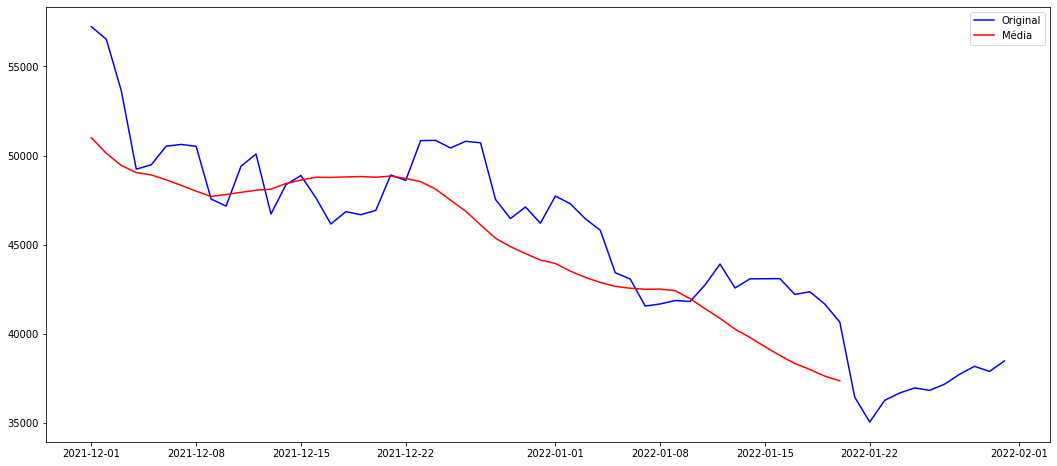

In [11]:
# Modelos de Médias Móveis (Suavização)

mmm = pd.DataFrame.rolling(df,window=12,center=False).mean()
orig = plt.plot(df, color='blue',label='Original')
mean = plt.plot(mmm, color='red',label='Média')
plt.legend(loc='best')
plt.show()

In [12]:
# aplica o método para obter previsões para até 12 passos à frente (horizonte)

import numpy as np

def medias_moveis(series, n):
    '''
        Calcula a média da últimas n observações
    '''
    return np.average(series[-n:])

In [13]:
medias_moveis(df, 12) # Previsão 12 passos à frente

51001.901666666665

In [14]:
# ARIMA(p,d,q)

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import warnings

warnings.filterwarnings("ignore")

#setando os dados de treinamento (70%) e teste (30%)
dados_treinamento, dados_teste = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
dados_treinamento = dados_treinamento['close'].values
dados_teste = dados_teste['close'].values
historico = [x for x in dados_treinamento]
modelo_preditivo = []

In [15]:
N_observacoes_teste = len(dados_teste)
for ponto_de_teste in range(N_observacoes_teste):
  modelo = ARIMA(historico, order=(1,1,0))  
  modelo_fit = modelo.fit(disp=0)
  saida = modelo_fit.forecast()
  yhat = saida[0]
  modelo_preditivo.append(yhat)
  valor_real_teste = dados_teste[ponto_de_teste]
  historico.append(valor_real_teste)

In [16]:
import matplotlib

erroMSE = mean_squared_error(dados_teste, modelo_preditivo)
print('O Erro Médio Quadrado (MSE) é {}'.format(erroMSE))

O Erro Médio Quadrado (MSE) é 3191600.037834051


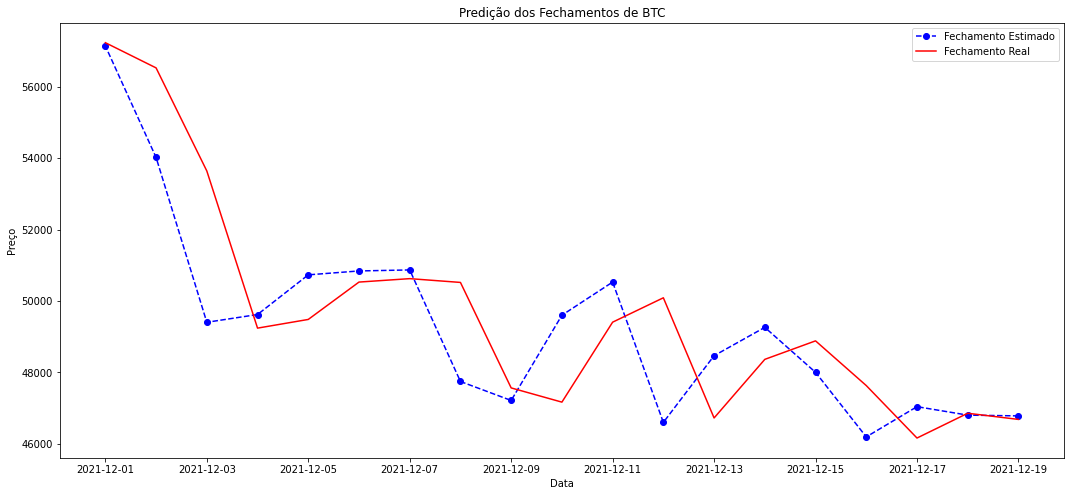

In [17]:
intervalo_dos_dados_de_teste = df[int(len(df)*0.7):].index
plt.plot(intervalo_dos_dados_de_teste, 
         modelo_preditivo, 
         color='blue', 
         marker='o', 
         linestyle='dashed',
         label='Fechamento Estimado')

plt.plot(intervalo_dos_dados_de_teste, 
         dados_teste, 
         color='red', 
         label='Fechamento Real')

plt.title('Predição dos Fechamentos de BTC')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()